In [1]:
#
# This is an example from jbr Reactor Design Book
# https://github.com/rawlings-group/paresto/blob/master/examples/green_book/bvsm_red.m
# 
# The simulation is done here with scipy
#

In [2]:
from kipet import KipetModel
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import t

    Set objects from pyomo.core.base.set or pyomo.core.  (deprecated in 5.7)
    (called from <frozen importlib._bootstrap>:219)
_SetProduct not found


In [3]:
filename = '/home/paperspace/learn_kipet/kipet_paresto/data_sets/flow.dat'
flow_df = pd.read_csv(filename, delimiter=r"\s+", header = None)
flow_df.columns = ['time', 'Qf', 'x']
flow_df['Qf'] = flow_df['Qf'] / 0.728
flow_df = flow_df.set_index('time')

In [4]:
flow_df

,Qf,x
time,,
9.0,0.134365,4.7860
19.0,1.772804,14.2180
29.0,1.734587,13.9980
39.0,1.703319,13.8180
49.0,1.669967,13.6260
...,...,...
829.0,0.000990,4.0182
839.0,0.000782,4.0170
849.0,0.000643,4.0162


In [5]:
filename = '/home/paperspace/learn_kipet/kipet_paresto/data_sets/lc.dat'
lc_data = pd.read_csv(filename, delimiter=r"\s+", header = None)
lc_data.columns = ['time', 'y']
lc_data = lc_data.set_index('time')

In [6]:
lc_data

,y
time,
414,0.1705
424,0.1604
434,0.1325
444,0.1084
493,0.1014
503,0.1042
513,0.1045
523,0.0970
533,0.0824


In [7]:
qinB_row0 = pd.DataFrame({'time':[0], 'qin_B':[0]}).set_index('time')
qinB_traj = flow_df[['Qf']]
qinB_traj.columns = ['qin_B']
qinB_traj = qinB_traj.append(qinB_row0).sort_index()
qinB_traj.head()

,qin_B
time,
0.0,0.000000
9.0,0.134365
19.0,1.772804
29.0,1.734587
39.0,1.703319


In [86]:
kipet_model = KipetModel()

r1 = kipet_model.new_reaction('rxn1')

r1.add_component('V', state = 'state', init = 2370)
r1.add_component('eps2', state = 'concentration', init = 0.0)

r1.add_algebraic_variables(['qin_B'])

r1.add_parameter('k',init = 2.48)
r1.add_parameter('na0', init = 2.34)

cbf = 0.00721
V0 = 2370

In [87]:
def rule_odes(m,t):
    
    nBadded = (m.X[t, 'V'] - V0) * cbf
    
    exprs = dict()
    exprs['V'] = m.Y[t,'qin_B']
    exprs['eps2'] = m.Y[t,'qin_B'] * cbf / (1 + m.P['k']*(m.P['na0'] - nBadded + m.Z[t, 'eps2']) / (nBadded - 2 * m.Z[t,'eps2']))
    return exprs

r1.add_equations(rule_odes) 

In [85]:
def rule_algebraics(m, t):
    
    nBadded = (m.X[t, 'V'] - V0) * cbf
    nD = m.Z[t,'eps2']
    nC = nBadded - 2 * nD
    
    r = list()
    r.append(m.Y[t, 'y'] * (nC + 2 * nD) - nC)
    return r

r1.add_algebraics(rule_algebraics)

In [88]:
#r1.add_dataset('lc_data', category = 'custom', data = lc_data)
r1.add_dataset('Traj', category = 'trajectory', data = qinB_traj)

In [89]:
r1.fix_from_trajectory('Y', 'qin_B', 'Traj')
r1.set_times(0, 900)

In [90]:
r1.settings.collocation.nfe = 60
r1.settings.collocation.ncp = 3
r1.settings.collocation.scheme = 'LAGRANGE-RADAU'
#r1.settings.parameter_estimator['solver'] = 'k_aug'
r1.settings.solver.linear_solver = 'ma27'

In [91]:
r1.simulate()

times are: <class 'tuple'>


In [92]:
V = r1.results.X['V']
nBadded = (V - V0) * cbf
nD = r1.results.Z['eps2']
nC = nBadded - 2 * nD
resdf = pd.DataFrame({'V': V, 'nC': nC, 'nD': nD})
resdf.head()

,V,nC,nD
0.000000,2370.000000,0.000000,0.000000
2.325765,2370.260264,0.001850,0.000013
9.674235,2370.581659,0.004231,-0.000019
15.000000,2373.940537,0.028259,0.000076
17.325765,2377.260402,0.051898,0.000225


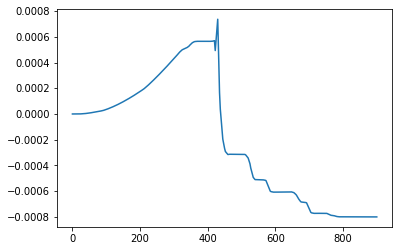

In [93]:
fig, ax = plt.subplots()
#ax.plot(resdf.index, resdf['nC'] / resdf['V'])
ax.plot(resdf.index, resdf['nD'] / resdf['V'])

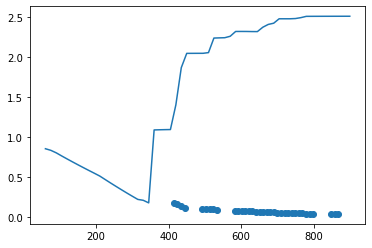

In [66]:
fig, ax = plt.subplots()
dfplt = r1.results.Y[r1.results.Y.index >= 50]
ax.scatter(lc_data.index, lc_data['y'])
ax.plot(dfplt.index, dfplt['y'])

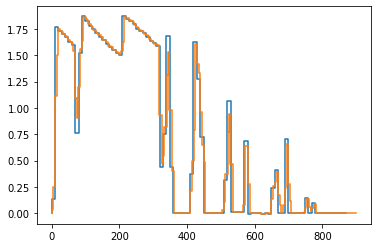

In [30]:
fig, ax = plt.subplots()
ax.step(qinB_traj.index, qinB_traj['qin_B'])
ax.step(r1.results.Y.index, r1.results.Y['qin_B'])